<h1 style="font-size:2em">Projet 7 - Implémentez un modèle de scoring</h1>


# Contexte

- Entreprise: "Pret à dépenser" -> Propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt
- **Objectif:** Création d'un “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé   
- Importance de la transparance (souhait des clients + valeurs de l'entreprise)
- **Dashboard interactif:** Pour pouvoir expliquer de façon la plus transparente possible les décisions d’octroi de crédit
    - Permet aussi à leurs clients de disposer de leurs informations personnelles et de les explorer facilement

# Objectifs 

1) Construire un **modèle de scoring** qui donnera une **prédiction (classification)** sur la **probabilité de faillite** d'un client de façon **automatique**
2) Construire un **dashboard interactif** permettant d'**interpréter les prédictions** faites par le modèle, et d’**améliorer la connaissance client** 
3) **Mettre en production** le modèle de scoring de prédiction à l’aide d’une **API**, ainsi que le **dashboard interactif qui appelle l’API** pour les prédictions
- ~~Utiliser des **kernels Kaggle (optionel)** pour faciliter l’analyse exploratoire, la préparation des données et le feature engineering nécessaires à l’élaboration du modèle de scoring~~

# Spécifications du dashbord

- Visualiser le score et l’interprétation de ce score pour chaque client de façon clair et simple
- Visualiser des informations descriptives relatives à un client (via un système de filtre)
- Comparer les informations descriptives d'un client à un groupe de clients similaires

# Partie technique

**Dahboard interactif:** Dash OU Bokeh OU Streamlit

Elaborer une plateforme MLOps:
https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P7/Outils+Open+Source+MLOps.pdf

- Librairie **evidently** pour détecter du **Data Drift** en production 
    - **Hypothèse:** “application_train” = datas pour la modélisation ET “application_test” = datas de nouveaux clients 
    - Créer un tableau HTML pour illustrer ce data drift

- **Déploiement de l'application dashboard et de l’API:** Plateforme Cloud (gratuit), plusieurs choix s'offrent à nous:
    - Azure webapp (ASP F1 gratuit)
    - PythonAnywhere
    - Heroku avec le package “student” de Github 

- Effectuer de la **Cross-Validation**

- Si les **scores scores AUC sont supérieurs à 0.82**, le modèle possède probablement de l’**overfitting** 

- Création d'une **note technique:** Présentera l’élaboration du modèle jusqu’à l’analyse du Data Drift

# Conseils sur l'elaboration du modèle

- Prendre en compte le **déséquilibre entre le nombre de bons et de moins bons clients** (utiliser une méthode au choix) 
- Prendre en compte le déséquilibre du **coût métier** entre entre un **faux négatif** et un **faux positif**:
    - **Faux négatif:** mauvais client prédit bon client : donc crédit accordé et perte en capital
    - **Faux positif:** Bon client prédit mauvais : donc refus crédit et manque à gagner en marge
    - Hypothèse: le coût d’un FN est **dix fois supérieur** au coût d’un FP
    
- **Création d'un score "métier":** Minimisation du coût d’erreur de prédiction des FN et FP
    - Ce score permet de choisir le **meilleur modèle** et ses **meilleurs hyperparamètres**
    - **Attention:** Minimisation score métier -> optimisation du seuil qui détermine, la classe 0 ou 1 
        - Un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum
    
- Utiliser aussi l'**ACU** et l'**accuracy** pour affiner notre modèle et ses hyperparamètres

# Livrable

- Application de dashboard interactif + l’API de prédiction du score, déployées chacunes sur le cloud.
- **Un dossier, géré via un outil de versioning** de code contenant:
    - **Notebook de la modélisation** (du prétraitement à la prédiction), intégrant via MLFlow le tracking d’expérimentations et le stockage centralisé des modèles
    - **Le code** générant le dashboard
    - **Le code** permettant de déployer le modèle sous forme d'API
    - **Un fichier** permettant de comprendre l'objectif du projet et le découpage des dossiers
    - **Un fichier** listant les packages utilisés 
    - **Tableau HTML** d’analyse de data drift réalisé à partir d’evidently
- Une **note méthodologique** (PDF?) décrivant:
    - La méthodologie d'entraînement du modèle (2 pages maximum)
    - Le traitement du déséquilibre des classes (1 page maximum)
    - La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
    - Un tableau de synthèse des résultats (1 page maximum)
    - L’interprétabilité globale et locale du modèle (1 page maximum)
    - Les limites et les améliorations possibles (1 page maximum)
    - L’analyse du Data Drift (1 page maximum)
- Un **support de présentation pour la soutenance** (Powerpoint)
    - Copies écran des commits, du dossier Github (+ lien vers ce dossier) et de l’exécution des tests unitaires
        - Ce sont les preuves qu’un pipeline de déploiement continu a permis de déployer l’API, doivent être formalisés dans ce support de présentation

# Imports et configs

In [1]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('df.csv', sep = ",")

In [3]:
df_classification = df[df['TARGET'].notnull()]
df_classification.shape

(307507, 773)

In [4]:
df_classification_imputed = df_classification.copy()
df_classification_imputed.fillna(df_classification.mean(), inplace=True)

**On va récupérer les résultats précédents CV grid et prendre les meilleurs combinaisons d'hyperparamètres pour chaque modèle**

## DummyClassifer

In [17]:
import mlflow
import pandas as pd
import subprocess

# Commande pour lancer le serveur MLflow
cmd = ["mlflow", "server", "--host", "127.0.0.1", "--port", "5000"]

# Lancer la commande
process = subprocess.Popen(cmd)

# Initialiser MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  

# Récupérer toutes les runs pour l'ID d'expérience spécifié
runs = mlflow.search_runs(experiment_ids=["772370665145895406"])

# Convertir en dataframe pandas
df_dummy = pd.DataFrame(runs)

df_dummy = df_dummy.filter(regex='^(metrics\.|params\.)').sort_values(by="metrics.Business Score", ascending=True)

In [18]:
df_dummy

,metrics.Business Score,metrics.Prediction Time,metrics.Fit Time,metrics.Accuracy,metrics.AUC,params.Strategy
1,248250.0,4.049973,0.012028,0.91927,0.500000,uniform
2,248250.0,4.026001,0.011000,0.91927,0.499998,prior
3,248250.0,3.857030,0.011001,0.91927,0.500000,most_frequent
4,250778.0,4.007998,0.011032,0.85146,0.500523,stratified
0,282682.0,3.974031,0.011999,0.08073,0.500000,constant


In [22]:
df_dummy["params.Strategy"].iloc[0]

'uniform'

In [63]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import gc
import time

# 1. Prétraiter les données
X = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification_imputed["TARGET"]

# 2. Diviser les données en train et test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

strategy = df_dummy["params.Strategy"].iloc[0]  # Assuming you're getting the strategy from here

# Définir l'URI de suivi pour MLflow
mlflow.set_tracking_uri("file:./mlruns")

mlflow.set_experiment("BestModels")

with mlflow.start_run(run_name="DummyClassifier"):
    dummy = DummyClassifier(strategy=strategy, constant=1 if strategy == 'constant' else None)

    # Mesurer le temps de traitement de fit
    start_time_fit = time.time()
    dummy.fit(X_train, y_train)
    elapsed_time_fit = time.time() - start_time_fit

    # Mesurer le temps de traitement de prédiction
    start_time_predict = time.time()
    y_prob = dummy.predict_proba(X_test)[:, 1]
    elapsed_time_predict = time.time() - start_time_predict
    
    y_pred = (y_prob > 0.5)

    # Calcul des scores
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cost = fp + 10 * fn

    # Log avec MLflow
    mlflow.log_param("Strategy", strategy)
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("Business Score", cost)
    mlflow.log_metric("Fit Time", elapsed_time_fit)
    mlflow.log_metric("Prediction Time", elapsed_time_predict)

    mlflow.sklearn.log_model(dummy, "dummy_model")

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.savefig("roc_curve.png")
    plt.close()
    mlflow.log_artifact("roc_curve.png")
    
    result = {
        "Strategy": strategy,
        "AUC": auc,
        "Accuracy": acc,
        "Business Score": cost
    }

results_df = pd.DataFrame([result])

gc.collect()

3532

In [64]:
results_df_dummy = results_df
results_df_dummy

,Strategy,AUC,Accuracy,Business Score
0,uniform,0.5,0.919271,49650


## Régression logistique

In [27]:
import mlflow
import pandas as pd
import subprocess

# Commande pour lancer le serveur MLflow
cmd = ["mlflow", "server", "--host", "127.0.0.1", "--port", "5000"]

# Lancer la commande
process = subprocess.Popen(cmd)

# Initialiser MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  

# Récupérer toutes les runs pour l'ID d'expérience spécifié
runs = mlflow.search_runs(experiment_ids=["424467287303037937"])

# Convertir en dataframe pandas
df_logistic = pd.DataFrame(runs)

df_logistic = df_logistic.filter(regex='^(metrics\.|params\.)').sort_values(by="metrics.Business Score", ascending=True)

In [28]:
df_logistic

,metrics.Business Score,metrics.Prediction Time,metrics.Fit Time,metrics.Accuracy,metrics.AUC,params.Threshold,params.C
2,156247.0,0.001000,763.526664,0.729222,0.772000,0.52,71.43846560856923
28,156278.0,0.000000,741.792686,0.729268,0.772001,0.52,50.0473664000777
39,156322.0,0.000000,744.776505,0.729213,0.771973,0.52,51.77556691900213
18,156334.0,0.001001,770.885014,0.729261,0.771971,0.52,61.68797113544631
24,156348.0,0.000000,750.958303,0.729216,0.771989,0.52,81.45625789057677
27,156358.0,0.000000,741.828451,0.729213,0.771991,0.52,63.355949127228826
8,156380.0,0.000000,766.539998,0.729258,0.771978,0.52,62.97282057899757
36,156411.0,0.000000,766.666003,0.729128,0.771995,0.52,92.72831891668886
38,156423.0,0.000000,754.104680,0.729206,0.772003,0.52,51.80173712575133
7,156438.0,0.000000,775.199993,0.729216,0.771986,0.52,56.50155885003453


In [34]:
float(df_logistic["params.Threshold"].iloc[0])

0.52

In [35]:
float(df_logistic["params.C"].iloc[0])

71.43846560856923

In [65]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import time
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import gc
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.simplefilter('ignore', ConvergenceWarning)

start_time = time.time()

# Définir l'URI de suivi pour MLflow
mlflow.set_tracking_uri("file:./mlruns")

# Configuration initiale de MLflow
mlflow.set_experiment("BestModels")

nb_0 = (df_classification_imputed['TARGET'] == 0).sum()
nb_1 = (df_classification_imputed['TARGET'] == 1).sum()

X = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification_imputed["TARGET"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
class_weights = {0: 1, 1: nb_0 / nb_1}
results = []

C_val = float(df_logistic["params.C"].iloc[0])
threshold = float(df_logistic["params.Threshold"].iloc[0])

model = LogisticRegression(C=C_val, class_weight=class_weights, verbose=1, max_iter=1000)

start_fit_time = time.time()
model.fit(X_train, y_train)
fit_duration = time.time() - start_fit_time

start_pred_time = time.time()
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = y_prob > threshold
pred_duration = time.time() - start_pred_time

auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cost = fp + 10 * fn

results.append({
    "C": C_val,
    "Threshold": threshold,
    "AUC": auc,
    "Accuracy": acc,
    "Business Score": cost
})

with mlflow.start_run(run_name="Logistic_Regression"):
    mlflow.log_param("C", C_val)
    mlflow.log_param("Threshold", threshold)
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("Business Score", cost)
    mlflow.log_metric("Fit Time", fit_duration)
    mlflow.log_metric("Prediction Time", pred_duration)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.savefig("roc_curve.png")
    plt.close()
    mlflow.log_artifact("roc_curve.png")

    mlflow.sklearn.log_model(model, "model")
    
    result = {
    "Strategy": strategy,
    "AUC": auc,
    "Accuracy": acc,
    "Business Score": cost
    }

results_df = pd.DataFrame([result])

gc.collect()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Temps écoulé: {elapsed_time:.2f} secondes")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished


Temps écoulé: 180.85 secondes


In [66]:
results_df_logistic = results_df
results_df_logistic

,Strategy,AUC,Accuracy,Business Score
0,uniform,0.77299,0.730285,31204


## LightGBM

L'avantage du LightGBM c'est qu'il marche bien avec des colonnes avec des NaN (on ne dénature pas le dataset avec une imputation)

In [4]:
import mlflow
import pandas as pd
import subprocess

# Commande pour lancer le serveur MLflow
cmd = ["mlflow", "server", "--host", "127.0.0.1", "--port", "5000"]

# Lancer la commande
process = subprocess.Popen(cmd)

# Initialiser MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  

# Récupérer toutes les runs pour l'ID d'expérience spécifié
runs = mlflow.search_runs(experiment_ids=["948990283897291215"])

# Convertir en dataframe pandas
df_lightGBM = pd.DataFrame(runs)

df_lightGBM = df_lightGBM.filter(regex='^(metrics\.|params\.)').sort_values(by="metrics.Business Score", ascending=True)

In [5]:
df_lightGBM

,metrics.AUC,metrics.Accuracy,metrics.Business Score,metrics.Fit Time,metrics.Prediction Time,params.Learning Rate,params.Threshold,params.N Estimators,params.Num Leaves
0,0.787351,0.736048,149513.0,681.888050,0.000997,0.016914256489425572,0.48,672,55
6,0.787115,0.733775,149753.0,451.670027,0.000000,0.026320139774869022,0.48,448,50
2,0.787132,0.729307,149759.0,548.166309,0.000000,0.01954684642604801,0.48,532,50
5,0.786871,0.727889,149808.0,498.642035,0.000000,0.021349976293399114,0.48,474,50
7,0.786997,0.738985,149933.0,401.260073,0.001000,0.028616695704190512,0.49,416,45
8,0.787091,0.741918,150003.0,381.966041,0.000000,0.03213952826726876,0.49,405,45
11,0.786588,0.755046,150070.0,345.876046,0.000994,0.044663652705991194,0.49,401,46
9,0.787141,0.740279,150138.0,391.931244,0.000000,0.030553921177597886,0.49,412,45
1,0.787357,0.765706,150176.0,530.418002,0.001028,0.02448578023421516,0.51,588,49
10,0.786859,0.740995,150260.0,403.200977,0.001000,0.029882981409189893,0.49,418,46


In [6]:
int(df_lightGBM["params.N Estimators"].iloc[0])

672

In [7]:
float(df_lightGBM["params.Learning Rate"].iloc[0])

0.016914256489425572

In [8]:
float(df_lightGBM["params.Threshold"].iloc[0])

0.48

In [9]:
int(df_lightGBM["params.Num Leaves"].iloc[0])

55

In [10]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import gc
import time
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

start_time = time.time()

# Définir l'URI de suivi pour MLflow
mlflow.set_tracking_uri("file:./mlruns")

# Configuration initiale de MLflow
mlflow.set_experiment("BestModels")

# Supposition : vous avez déjà votre dataframe 'df_classification' chargé
nb_0 = (df_classification['TARGET'] == 0).sum()
nb_1 = (df_classification['TARGET'] == 1).sum()

X = df_classification.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification["TARGET"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
class_weights = {0: 1, 1: nb_0 / nb_1}
results = []

# Définissez les paramètres souhaités ici
lr = float(df_lightGBM["params.Learning Rate"].iloc[0])
num_leaves = int(df_lightGBM["params.Num Leaves"].iloc[0])
n_estimators = int(df_lightGBM["params.N Estimators"].iloc[0])
threshold = float(df_lightGBM["params.Threshold"].iloc[0])

model = LGBMClassifier(learning_rate=lr, num_leaves=num_leaves, n_estimators=n_estimators, class_weight=class_weights, verbose=1)

start_fit_time = time.time()
model.fit(X_train, y_train)
fit_duration = time.time() - start_fit_time

start_pred_time = time.time()
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = y_prob > threshold
pred_duration = time.time() - start_pred_time

auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cost = fp + 10 * fn

results.append({
    "Learning Rate": lr,
    "Num Leaves": num_leaves,
    "Threshold": threshold,
    "AUC": auc,
    "Accuracy": acc,
    "Business Score": cost
})

with mlflow.start_run(run_name="LightGBM"):
    mlflow.log_param("Learning Rate", lr)
    mlflow.log_param("Num Leaves", num_leaves)
    mlflow.log_param("N Estimators", n_estimators) 
    mlflow.log_param("Threshold", round(threshold, 2))
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("Business Score", cost)
    
     # Enregistrer les temps dans mlflow
    mlflow.log_metric("Fit Time", fit_duration)
    mlflow.log_metric("Prediction Time", pred_duration)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.savefig("roc_curve.png")
    plt.close()
    mlflow.log_artifact("roc_curve.png")

    mlflow.sklearn.log_model(model, "model")

# 6. Afficher les résultats
results_df = pd.DataFrame(results)

gc.collect()

end_time = time.time()
elapsed_time = end_time - start_time

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.694309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100653
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003
[LightGBM] [Info] Start training from score 0.000003


C:\Users\Utilisateur\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [11]:
results_df_lightGBM = results_df
results_df_lightGBM

,Learning Rate,Num Leaves,Threshold,AUC,Accuracy,Business Score
0,0.016914,55,0.48,0.790119,0.735683,29657


# Winner? 

LightGBM

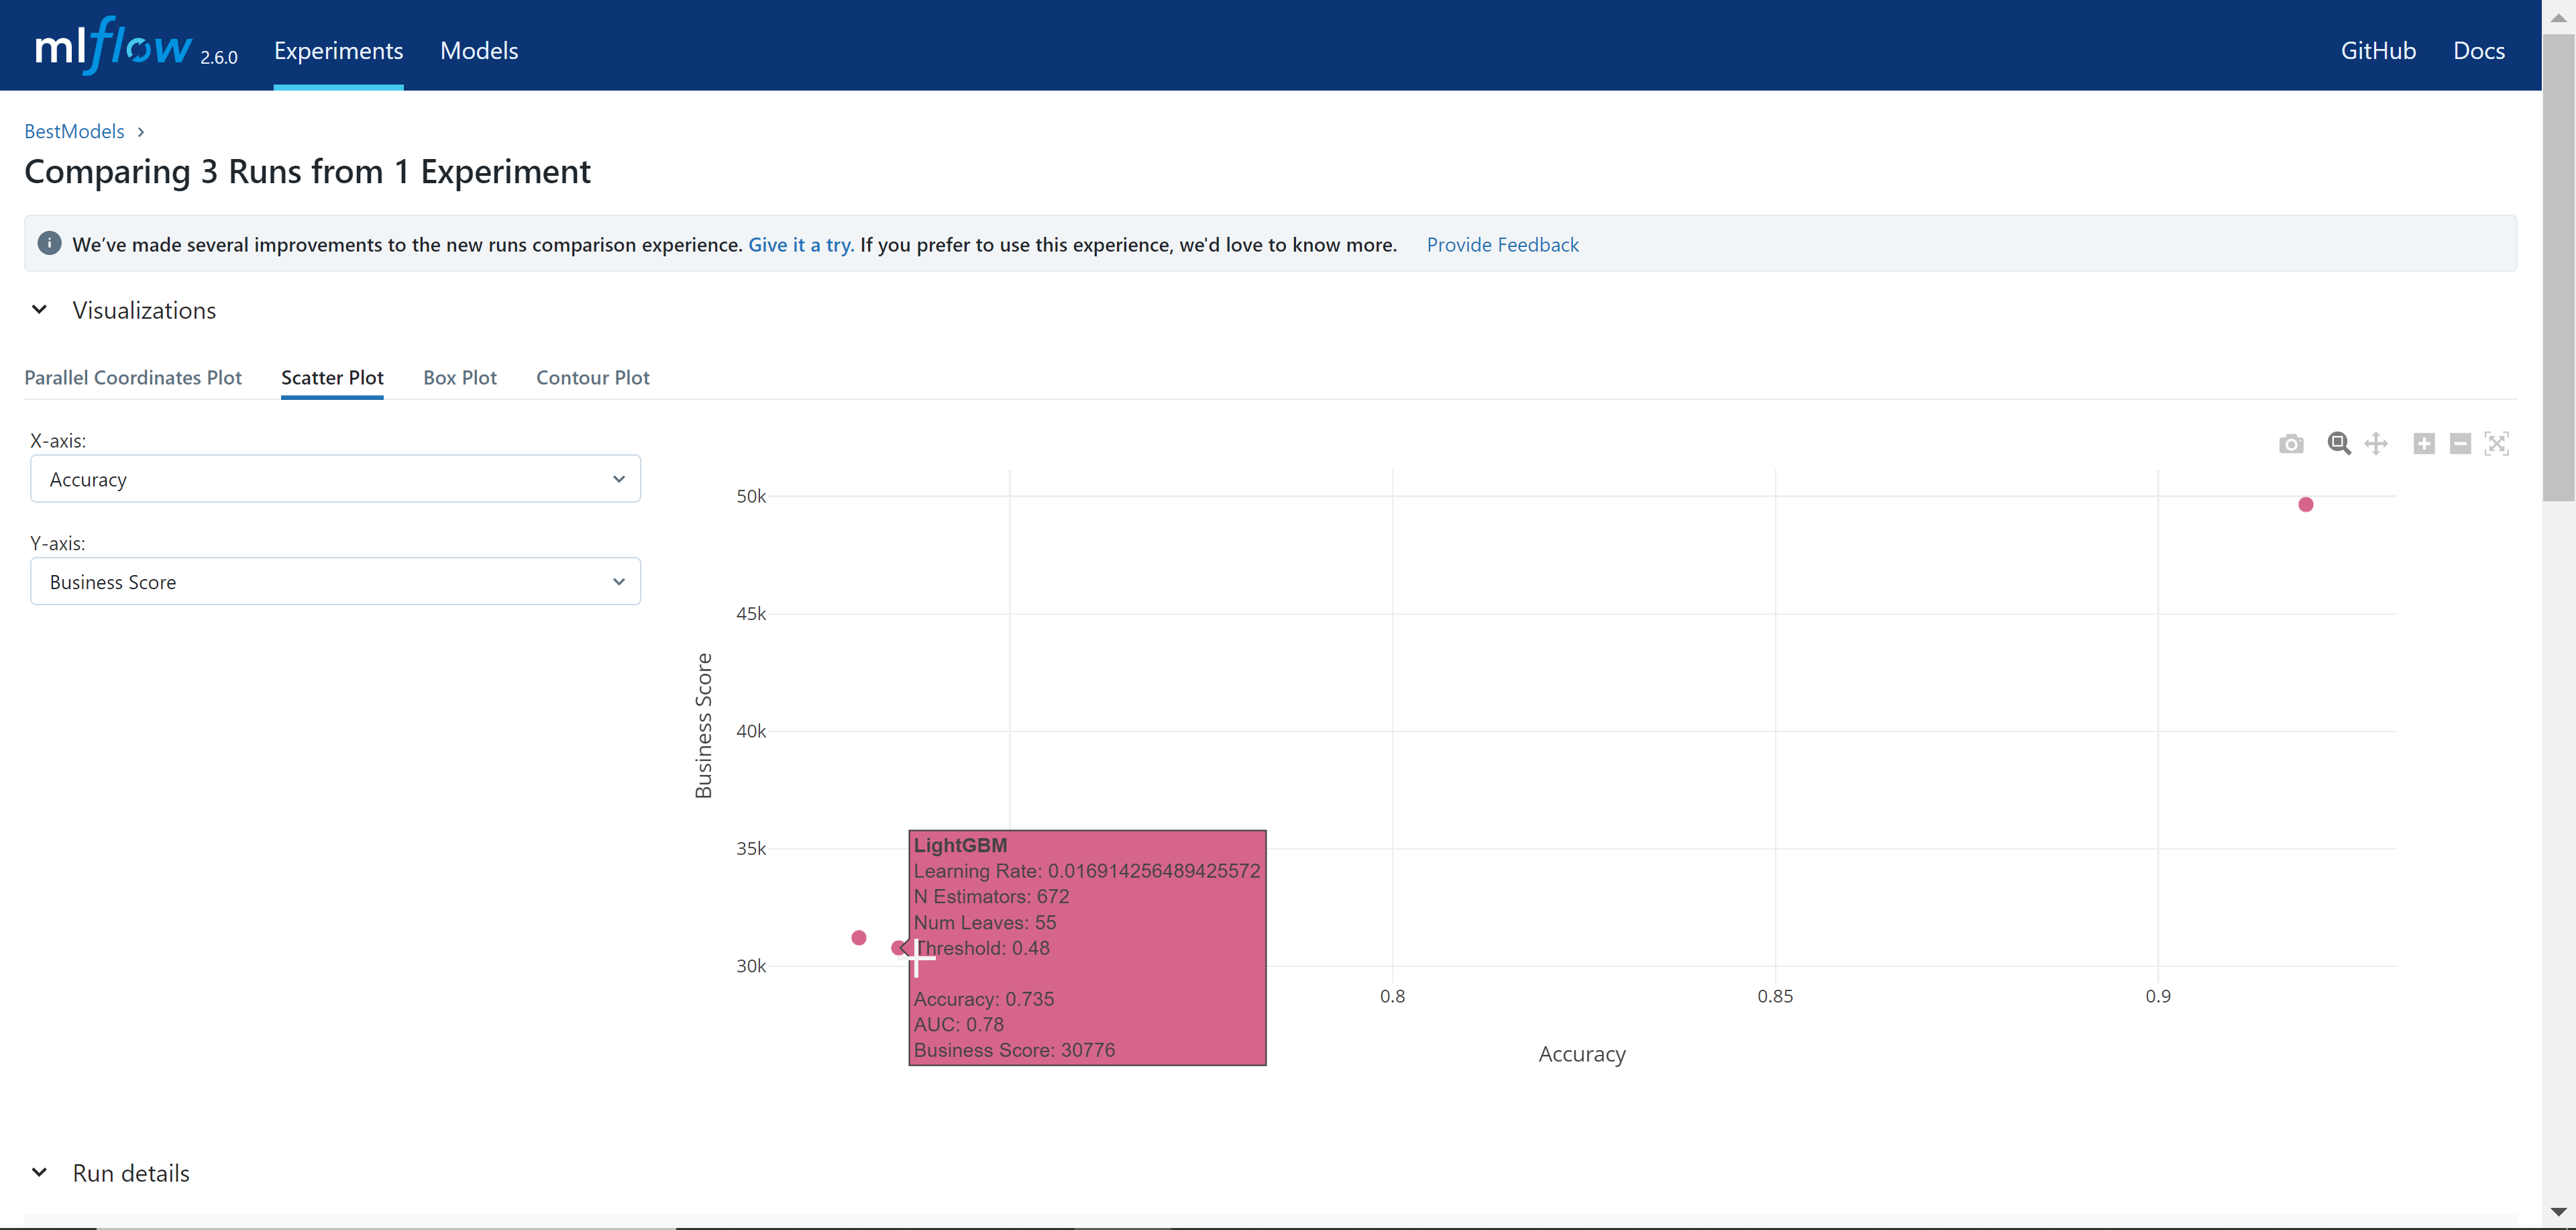

# Création csv test

In [75]:
df_test = df[df['TARGET'].isna()].drop(columns=['TARGET'])

In [77]:
print(df_test.shape)
df_test.head()

(48744, 772)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZA

In [78]:
df_test.to_csv('./Simulations/df_test.csv', index=False)

In [79]:
import gc
del df
gc.collect()

20008